# Task 3: Super-Resolution using Random Fourier Features (RFF)


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import cv2

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')
import os
import torch_xla.core.xla_model as xm

# Check for TPU availability, fallback to GPU if not available
if 'COLAB_TPU_ADDR' in os.environ:
    device = xm.xla_device()  # Use TPU device
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU or CPU

print(f'Using device: {device}')
# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

Using device: cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 631.2 kB/s eta 0:00:00


#### Declaring all functions

In [2]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [3]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [4]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [5]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [6]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2),random_state=42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


#### Importing original image

In [7]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-09-19 10:27:43--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 18.160.143.19, 18.160.143.47, 18.160.143.125, ...
Connecting to segment-anything.com (segment-anything.com)|18.160.143.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.04s   

2024-09-19 10:27:44 (5.75 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [8]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


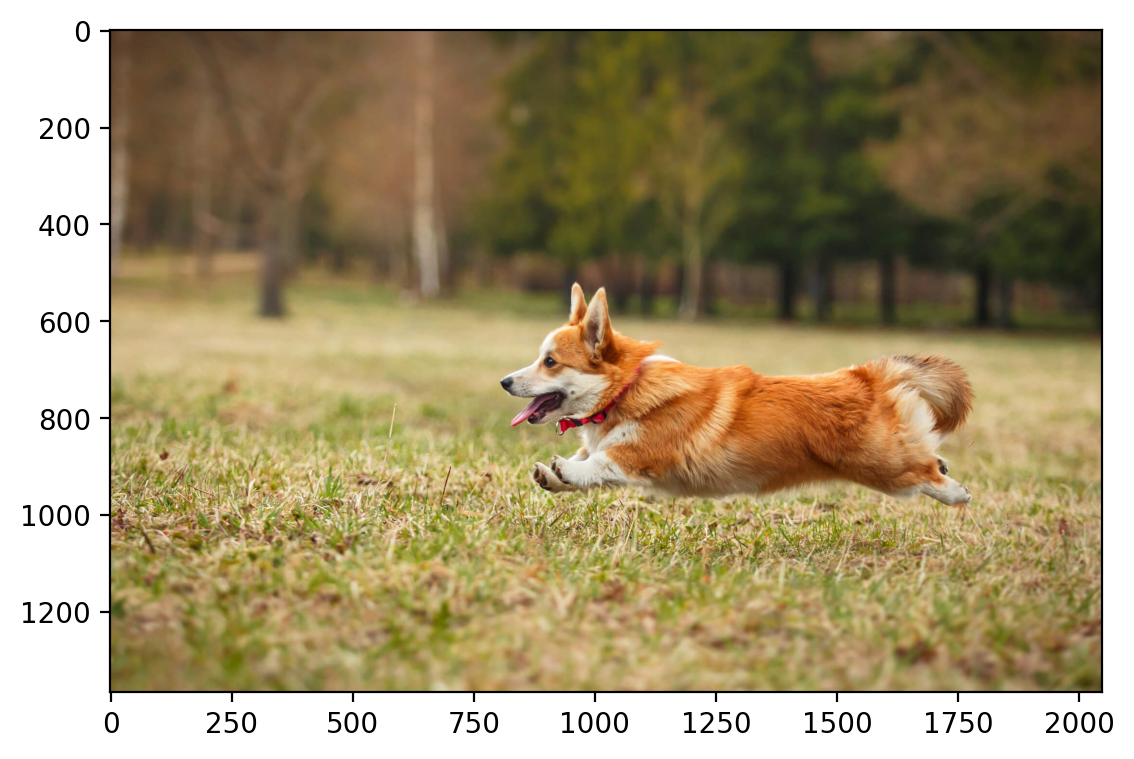

In [9]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


#### Cropping 400*400 image

In [10]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [11]:

img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)


In [12]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [13]:
img_scaled.shape

torch.Size([3, 1365, 2048])

In [14]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
crop.shape

torch.Size([3, 400, 400])

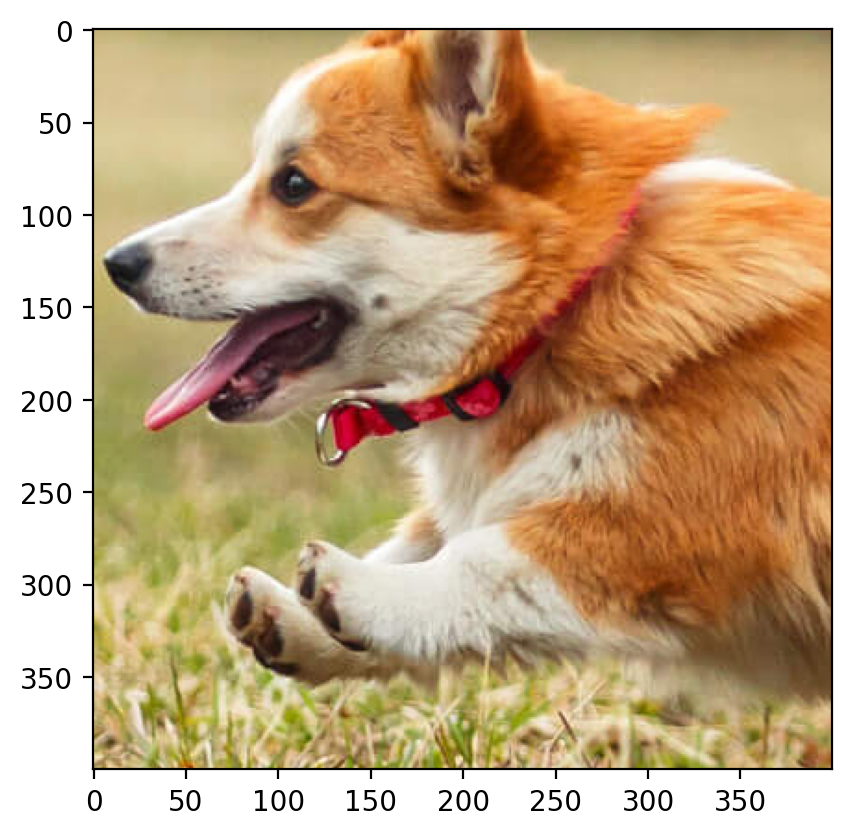

In [15]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


In [16]:
crop = crop.to(device)


In [17]:
crop

tensor([[[0.7686, 0.7686, 0.7686,  ..., 0.5608, 0.5608, 0.5608],
         [0.7725, 0.7725, 0.7725,  ..., 0.5608, 0.5608, 0.5608],
         [0.7765, 0.7765, 0.7765,  ..., 0.5569, 0.5569, 0.5569],
         ...,
         [0.6196, 0.6353, 0.6353,  ..., 0.6431, 0.6471, 0.6549],
         [0.6157, 0.6706, 0.7216,  ..., 0.6824, 0.7059, 0.7216],
         [0.6353, 0.6902, 0.7294,  ..., 0.7137, 0.7490, 0.7725]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.4706, 0.4706, 0.4706],
         [0.6980, 0.6980, 0.6980,  ..., 0.4706, 0.4706, 0.4706],
         [0.7020, 0.7020, 0.7020,  ..., 0.4784, 0.4784, 0.4784],
         ...,
         [0.5176, 0.5333, 0.5255,  ..., 0.4431, 0.4353, 0.4314],
         [0.5333, 0.5922, 0.6353,  ..., 0.5020, 0.5137, 0.5176],
         [0.5647, 0.6196, 0.6549,  ..., 0.5529, 0.5686, 0.5843]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.3373, 0.3373, 0.3373],
         [0.4784, 0.4784, 0.4784,  ..., 0.3373, 0.3373, 0.3373],
         [0.4824, 0.4824, 0.4824,  ..., 0.3412, 0.3412, 0.

In [18]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 400 400


#### Resizing to 200*200

In [19]:
low_res_image = cv2.resize(rearrange(crop, 'c h w -> h w c').cpu().numpy(), ( 200, 200))

In [20]:
type(low_res_image)

numpy.ndarray

In [21]:
low_res_image.shape

(200, 200, 3)

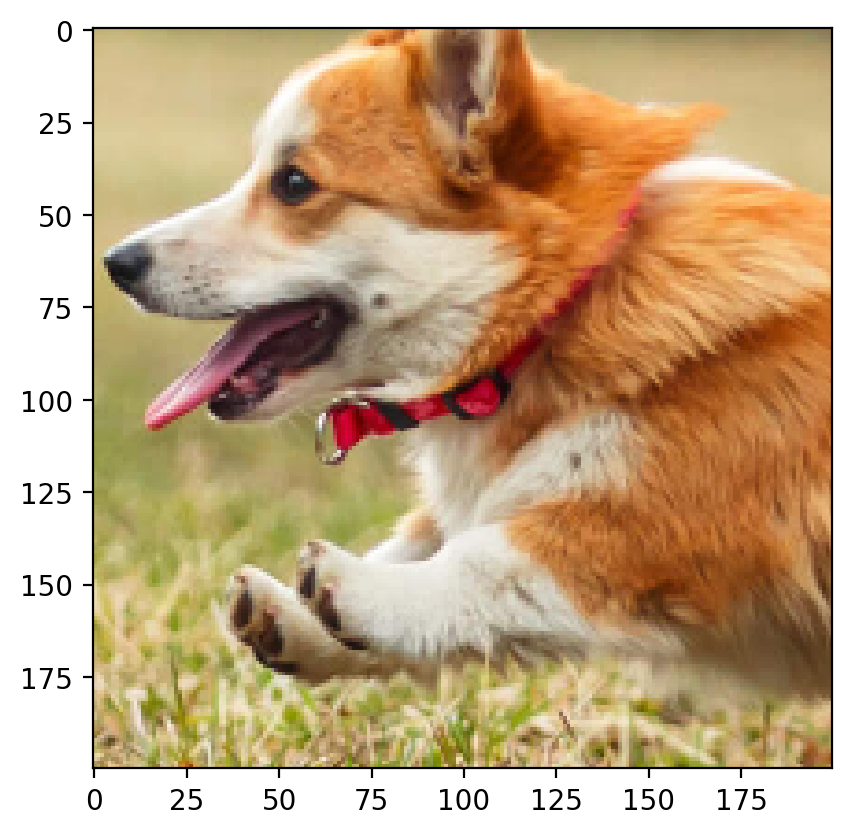

In [22]:
plt.imshow(low_res_image)

#### Creating RFF features for low res image

In [23]:
low_res_tensor = torch.tensor(low_res_image, dtype=torch.float32).permute(2, 0, 1).to(device)
X_low_res, Y_low_res = create_coordinate_map(low_res_tensor)

In [24]:
low_res_tensor.shape

torch.Size([3, 200, 200])

In [25]:
X_low_res

tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [199., 197.],
        [199., 198.],
        [199., 199.]])

In [26]:
scaler_1 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_low_res.cpu())

# Scale the X coordinates
X_low_res_scaled = scaler_1.transform(X_low_res.cpu())

# Move the scaled X coordinates to the GPU
X_low_res_scaled = torch.tensor(X_low_res_scaled).to(device)

# Set to dtype float32
X_low_res_scaled = X_low_res_scaled.float()

In [27]:
rff_features_low_res = create_rff_features(X_low_res_scaled, num_features=40000, sigma=0.008)

In [28]:
rff_features_low_res.shape

torch.Size([40000, 40000])

#### Training model on low res image

In [29]:
model = LinearModel(in_features=rff_features_low_res.shape[1], out_features=Y_low_res.shape[1]).to(device)

In [30]:
train(model, 0.005, rff_features_low_res, Y_low_res, 1000)

Epoch 0 loss: 0.365433
Epoch 100 loss: 0.042319
Epoch 200 loss: 0.007450
Epoch 300 loss: 0.003219
Epoch 400 loss: 0.001766
Epoch 500 loss: 0.001049
Epoch 600 loss: 0.000674
Epoch 700 loss: 0.000471
Epoch 800 loss: 0.000355
Epoch 900 loss: 0.000288


0.00024759076768532395

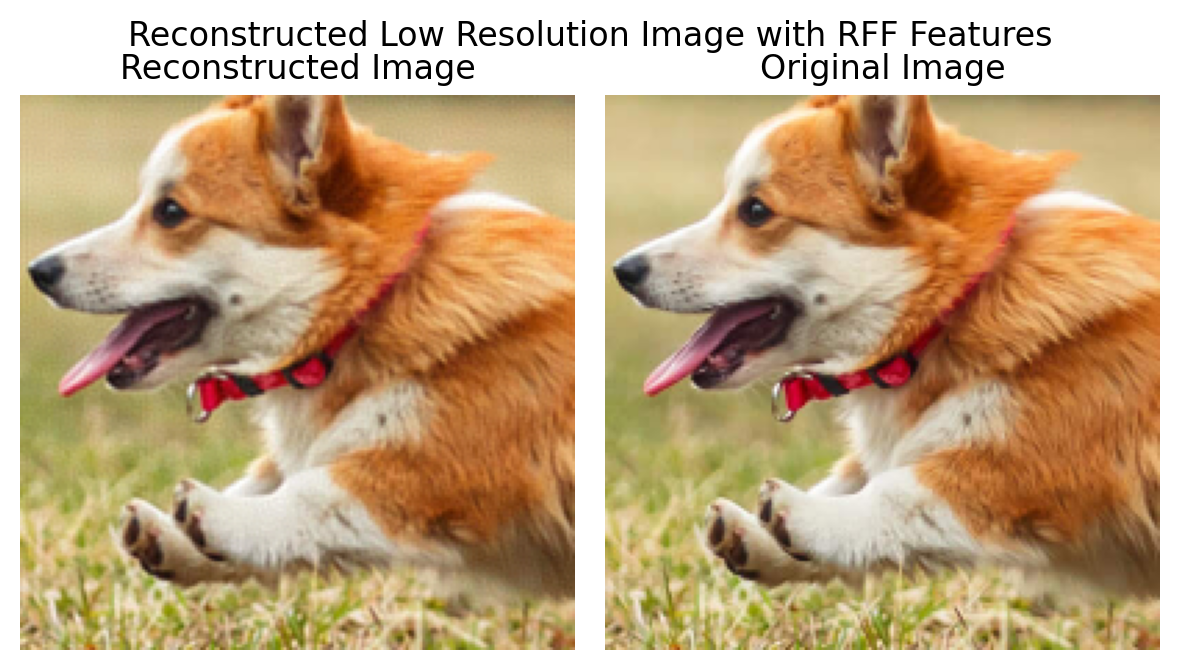

In [32]:
plot_reconstructed_and_original_image(low_res_tensor, model, rff_features_low_res, title="Reconstructed Low Resolution Image with RFF Features")


#### Creating RFF features for high res image

In [33]:
high_res_tensor = torch.tensor(crop,dtype=torch.float32).to(device)

In [34]:
high_res_tensor.shape

torch.Size([3, 400, 400])

In [35]:
X_high_res, Y_high_res = create_coordinate_map(high_res_tensor,scale=1)

In [36]:
X_high_res

tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [399., 397.],
        [399., 398.],
        [399., 399.]])

In [37]:
#Creating coordinate map for high resolution image
scaling_factor=2
X2,y2=create_coordinate_map(low_res_tensor,scale=scaling_factor)

In [38]:
X2

tensor([[  0.0000,   0.0000],
        [  0.0000,   0.5000],
        [  0.0000,   1.0000],
        ...,
        [199.5000, 198.5000],
        [199.5000, 199.0000],
        [199.5000, 199.5000]])

In [39]:
X2.shape

torch.Size([160000, 2])

In [40]:

# MinMaxScaler from -1 to 1
scaler_2 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X2.cpu())

# Scale the X coordinates
X2_scaled = scaler_2.transform(X2.cpu())

# Move the scaled X coordinates to the GPU
X2_scaled = torch.tensor(X2_scaled)

# Set to dtype float32
X2_scaled = X2_scaled.float()

In [41]:
X2_scaled

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        ...,
        [ 1.0000,  0.9900],
        [ 1.0000,  0.9950],
        [ 1.0000,  1.0000]])

In [42]:
rff_features_high_res = create_rff_features(X2_scaled, num_features=40000, sigma=0.008)

In [43]:
rff_features_high_res.shape

torch.Size([160000, 40000])

#### Generating super resolution image

In [44]:
num_channels, height, width = high_res_tensor.shape
model.eval()
with torch.no_grad():
    outputs = model(rff_features_high_res)
    outputs = outputs.reshape(height, width, num_channels)

In [60]:
def min_max_scale_3d(arr):
    arr_min = arr.min(axis=(0, 1), keepdims=True)  # Minimum value per feature
    arr_max = arr.max(axis=(0, 1), keepdims=True)  # Maximum value per feature
    scaled_arr = (arr - arr_min) / (arr_max - arr_min)
    return scaled_arr


In [69]:
outputs_scaled = min_max_scale_3d(outputs.cpu().numpy())
outputs_scaled_tensor= torch.tensor(outputs_scaled,dtype=torch.float32).to(device)


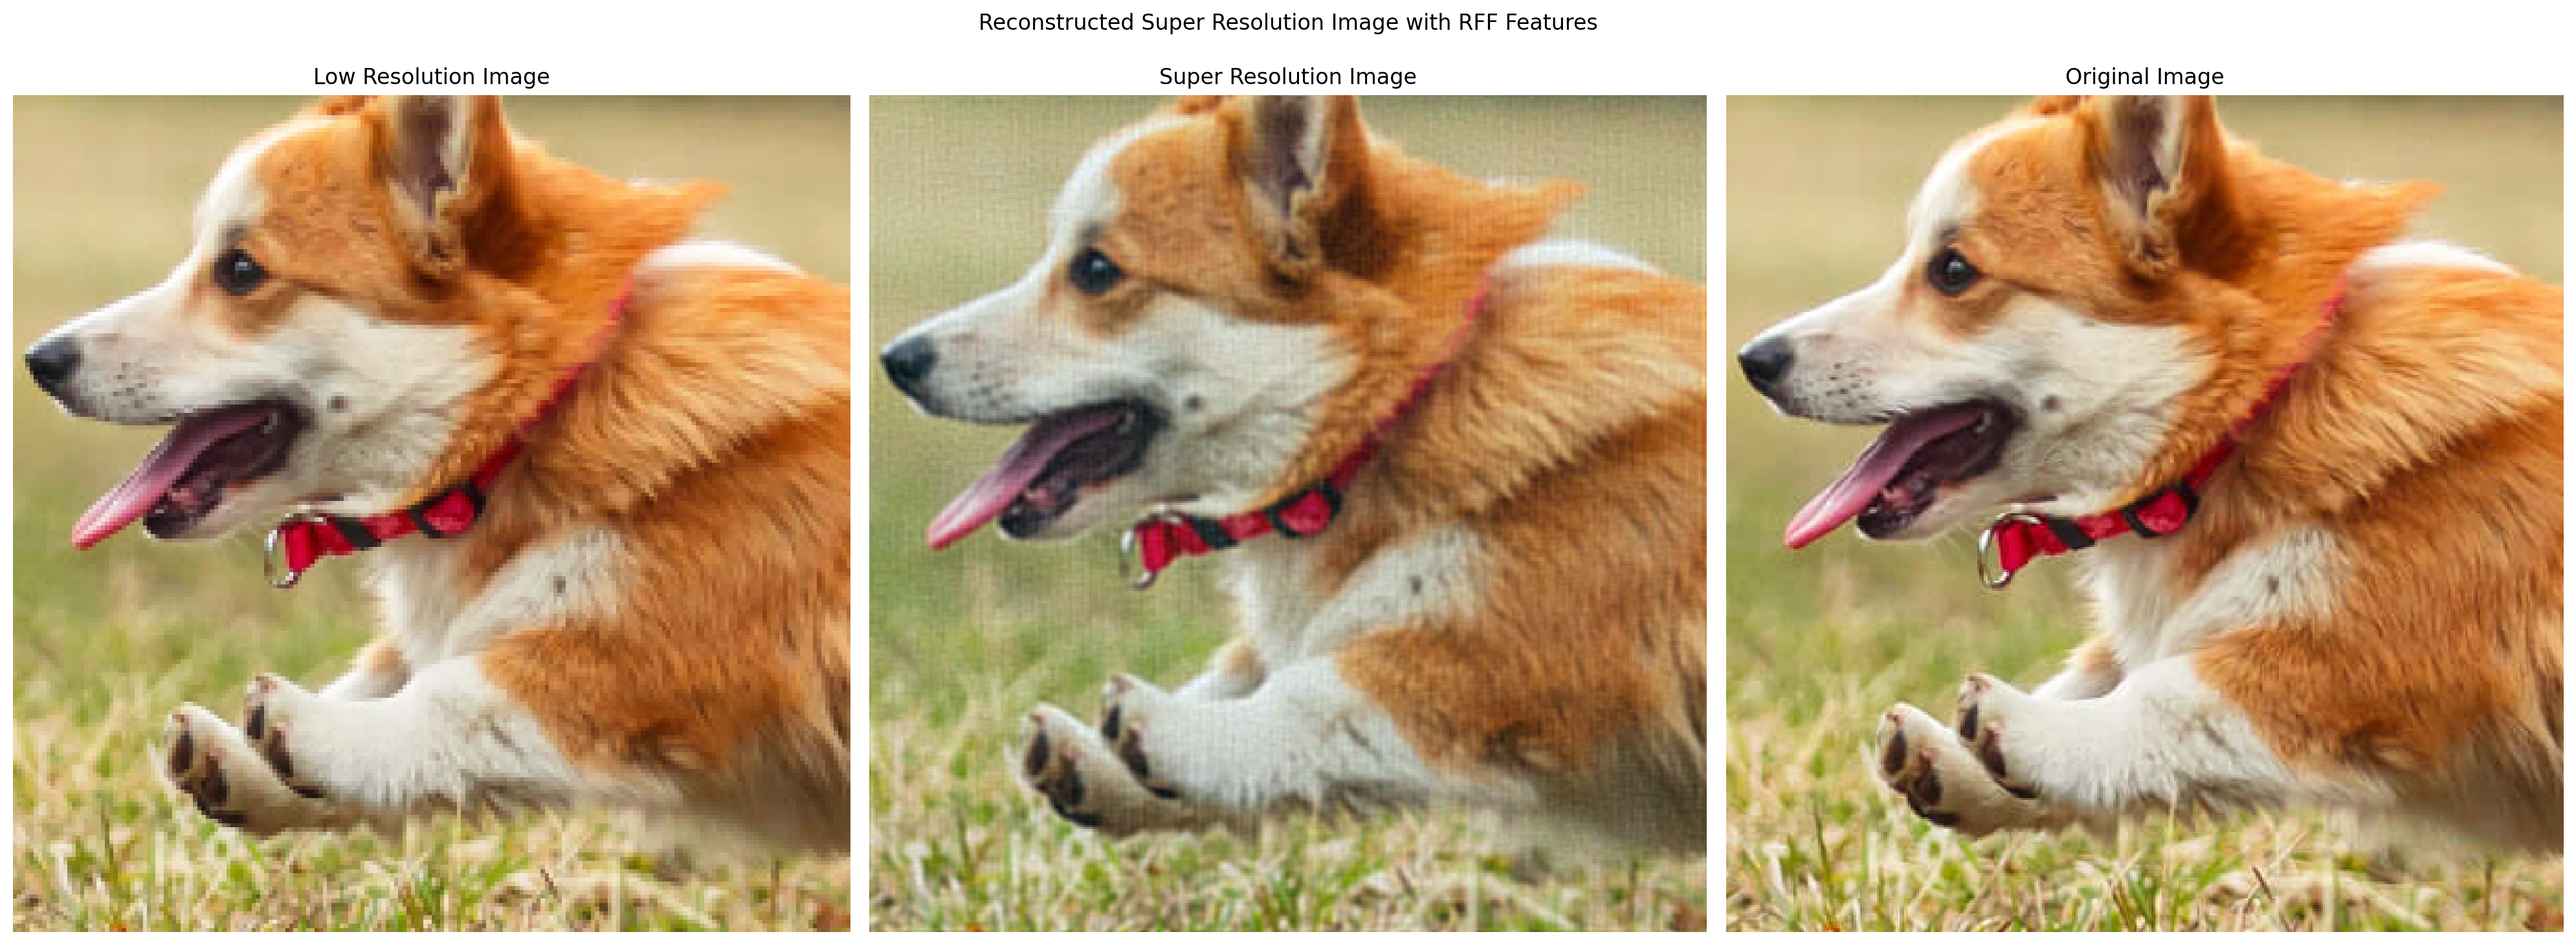

In [70]:

fig = plt.figure(figsize=(20, 8))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])


ax0.imshow(low_res_tensor.cpu().permute(1,2,0))
ax0.set_title("Low Resolution Image")


ax1.imshow(outputs_scaled_tensor.cpu())
ax1.set_title("Super Resolution Image")


ax2.imshow(high_res_tensor.cpu().permute(1, 2, 0))
ax2.set_title("Original Image")

for a in [ax0, ax1, ax2]:
    a.axis("off")


fig.suptitle("Reconstructed Super Resolution Image with RFF Features\n", y=0.95)
plt.tight_layout()

## RMSE on predicted v/s ground truth high resolution image

In [74]:
output_tensor= outputs_scaled_tensor.permute(2,0,1)

In [75]:
output_tensor.shape

torch.Size([3, 400, 400])

In [85]:
mse=torch.mean((high_res_tensor-output_tensor)**2)
rmse=torch.sqrt(mse)
print("RMSE=",rmse.item())

RMSE= 0.053277745842933655


#### Peak SNR on predicted v/s ground truth high resolution image

In [86]:
mx=torch.max(high_res_tensor).float()
psnr=10*torch.log10((mx**2)/mse)
print("PSNR=",psnr.item())

PSNR= 25.469083786010742
